# DeepLab Demo

This demo will demostrate the steps to run deeplab semantic segmentation model on sample input images.

In [1]:
#@title Imports

import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

import time
import sys

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
import cv2

In [2]:
from IPython.display import display
from ipywidgets import interact
from ipywidgets import interactive
import ipywidgets as widgets

In [3]:
#@title Helper methods


class DeepLabModel(object):
    """Class to load deeplab model and run inference."""
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    
    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        
        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        
        tar_file.close()
        
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')
            
        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
            
        self.sess = tf.Session(graph=self.graph)
        
    def run(self, image):
        """Runs inference on a single image.

        Args:
          image: A PIL.Image object, raw input image.

        Returns:
          resized_image: RGB image resized from original input image.
          seg_map: Segmentation map of `resized_image`.
        """
        height, width = image.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
#         resize_ratio = 1.0
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(image,target_size)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map


def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
          is the color indexed by the corresponding element in the input label
          to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
        map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])
    
    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')
    
    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')
    
    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')
    
    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
        FULL_COLOR_MAP[range(len(unique_labels))].astype(np.uint8), interpolation='nearest')
#     plt.imshow(
#         FULL_COLOR_MAP.astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[range(len(unique_labels))])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray([
    'bed                ','windowpane         ','cabinet            ','person             ','door               ',
    'table              ','curtain            ','chair              ','car                ','painting           ',
    'sofa               ','shelf              ','mirror             ','armchair           ','seat               ',
    'fence              ','desk               ','wardrobe           ','lamp               ','bathtub            ',
    'railing            ','cushion            ','box                ','column             ','signboard          ',
    'chest of drawers   ','counter            ','sink               ','fireplace          ','refrigerator       ',
    'stairs             ','case               ','pool table         ','pillow             ','screen door        ',
    'bookcase           ','coffee table       ','toilet             ','flower             ','book               ',
    'bench              ','countertop         ','stove              ','palm               ','kitchen island     ',
    'computer           ','swivel chair       ','boat               ','arcade machine     ','bus                ',
    'towel              ','light              ','truck              ','chandelier         ','awning             ',
    'streetlight        ','booth              ','television receiver','airplane           ','apparel            ',
    'pole               ','bannister          ','ottoman            ','bottle             ','van                ',
    'ship               ','fountain           ','washer             ','plaything          ','stool              ',
    'barrel             ','basket             ','bag                ','minibike           ','oven               ',
    'ball               ','food               ','step               ','trade name         ','microwave          ',
    'pot                ','animal             ','bicycle            ','dishwasher         ','screen             ',
    'sculpture          ','hood               ','sconce             ','vase               ','traffic light      ',
    'tray               ','ashcan             ','fan                ','plate              ','monitor            ',
    'bulletin board     ','radiator           ','glass              ','clock              ','flag               '
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [4]:
def set_model(model_name):
    return model_name

## Run on sample images

Select one of sample images (leave `IMAGE_URL` empty) or feed any internet image
url for inference.

Note that we are using single scale inference in the demo for fast computation,
so the results may slightly differ from the visualizations in
[README](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md),
which uses multi-scale and left-right flipped inputs.

In [5]:
import os
!ls
os.getcwd()

color_transfer.py	       model		Untitled.ipynb
DeepLab_ADE20K.ipynb	       non_TM_1k.ipynb	utils
DeepLab_CitySpace.ipynb        __pycache__	vgg19
DeepLab_PASCAL_VOC_2012.ipynb  sharpened.png	vgg_small_patch.ipynb
exp1			       summaries	vgg_TM.ipynb
hr			       test.png		wide_angle.png
lr			       Untitled1.ipynb


'/home/server/Desktop/jh/data/mantis/indoor/EXP'

# **DeepLab models trained on ADE20K**

In [6]:
w = interactive(set_model,model_name=[('xception65_ade20k_train','xception65_ade20k_train')])
display(w)

interactive(children=(Dropdown(description='model_name', options=(('xception65_ade20k_train', 'xception65_ade2…

In [7]:
MODEL_NAME = w.result
print('MODEL_NAME = '+ MODEL_NAME)

MODEL_NAME = xception65_ade20k_train


In [8]:
#@title Select and download models {display-mode: "form"}

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'xception65_ade20k_train':
        'deeplabv3_xception_ade20k_train_2018_05_29.tar.gz',
}

model_dir = '/home/server/Desktop/jh/pretrained_models/deeplabv3'

print('Loading DeepLab model...')
download_path = os.path.join(model_dir, _MODEL_URLS[MODEL_NAME])
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

Loading DeepLab model...
model loaded successfully!


In [9]:
def resize_seg_map(seg_map,target_size):
    seg_map_val = np.unique(seg_map)
    h,w = target_size
    res = np.zeros(shape=[h,w],dtype=np.float32)
    
    for i in range(len(seg_map_val)):
        thres = seg_map_val[i]
        tmp_mask = np.where(seg_map==thres,thres,0)
        tmp_mask = cv2.resize(tmp_mask/255.0,(w,h),interpolation=cv2.INTER_LINEAR)
        tmp_mask *= np.where(res!=0,0,1)
        tmp_mask = np.where(tmp_mask!=0,thres,0)
        res += tmp_mask*255.0
    return np.floor(res).astype(np.uint8)

## Segment lr image

### 1.read lr image

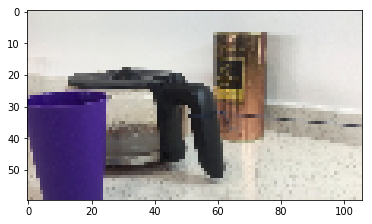

In [20]:
directory = "../dec20_2018/"
image_name = '00000.jpg'
img_1 = cv2.imread(directory+image_name)
img_1 = cv2.cvtColor(img_1,cv2.COLOR_BGR2RGB)
h,w = img_1.shape[:2]
# lr_orig = img_1
lr_orig = cv2.resize(img_1,(int(w/8),int(h/8)))
# img_ds_1 = cv2.resize(img_1,(int(513/8),int(384/8)))
# img_ds_1 = cv2.resize(img_ds_1,(w,h))

plt.imshow(lr_orig)

### 2.segment lr image

/home/server/anaconda3/envs/Chao/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


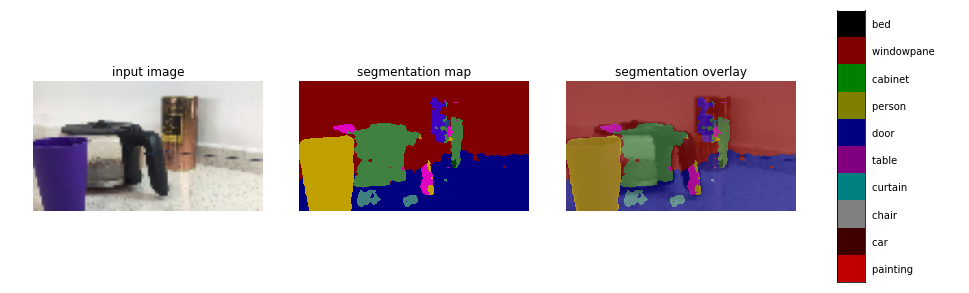

In [21]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
resized_im, seg_map = MODEL.run(lr_orig)
vis_segmentation(resized_im, seg_map)

### 3. resize segmentation map

/home/server/anaconda3/envs/Chao/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


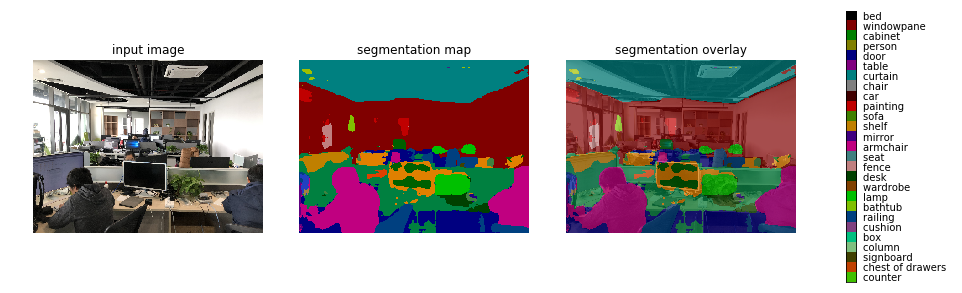

In [543]:
seg_map = resize_seg_map(seg_map,(int(h/8),int(w/8)))
seg_map = resize_seg_map(seg_map,(int(h/8),int(w/8)))
vis_segmentation(lr_orig, seg_map)

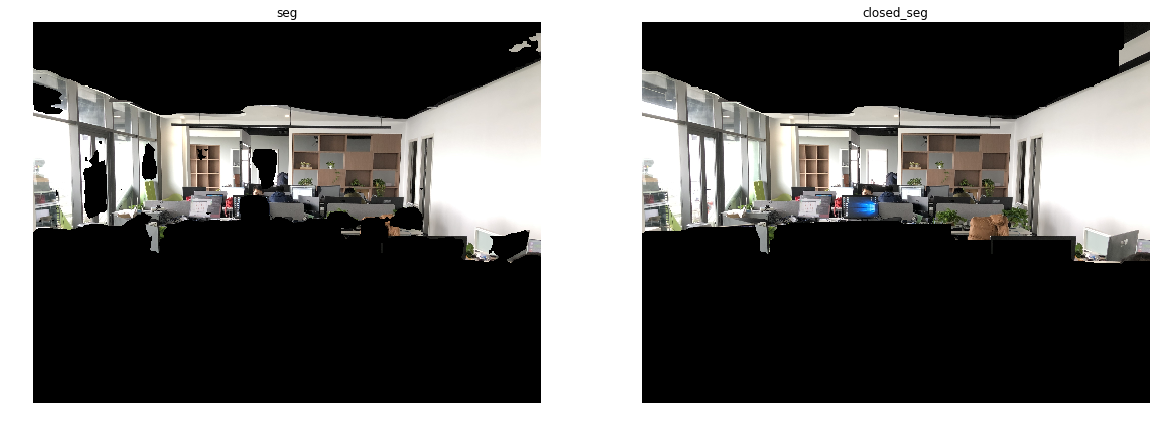

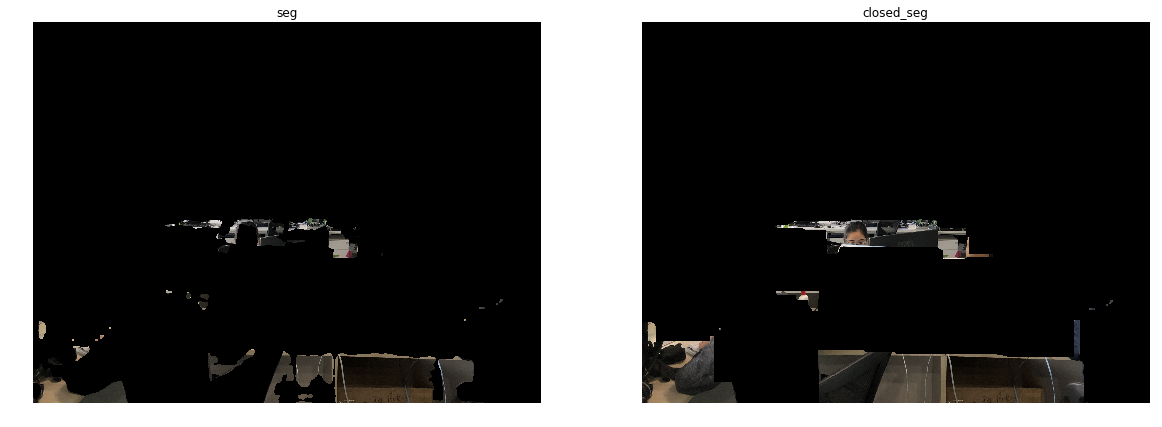

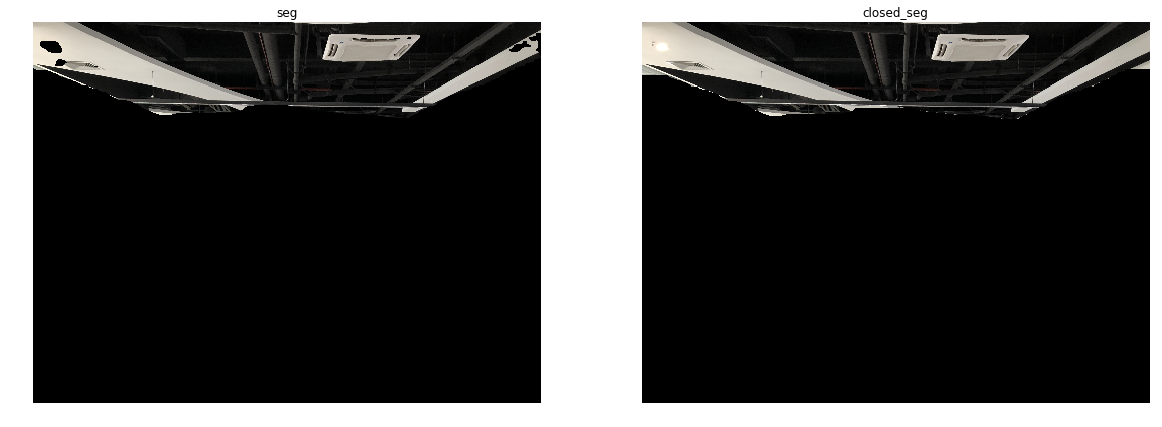

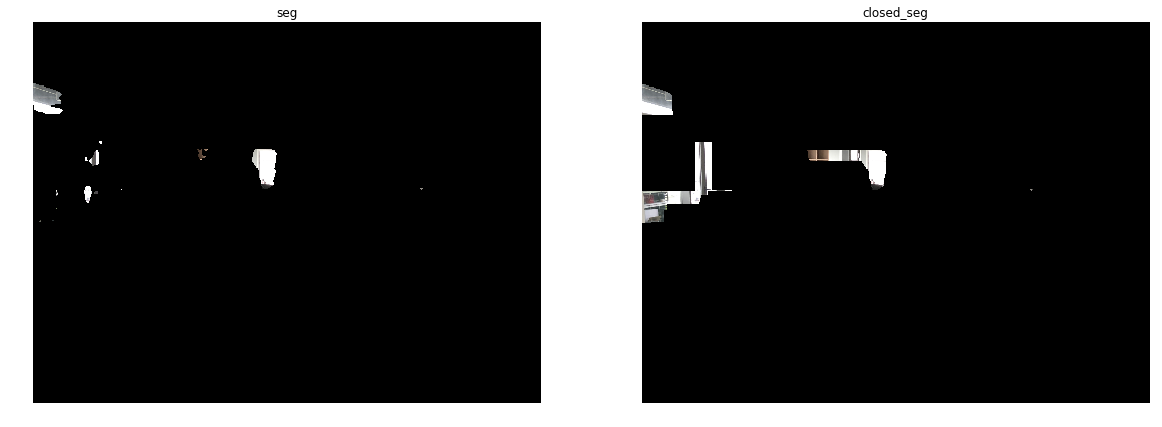

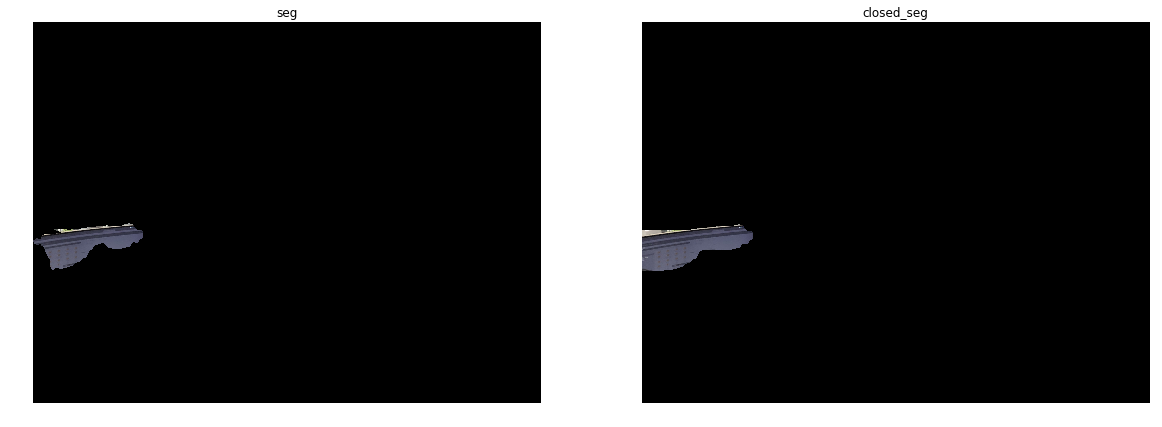

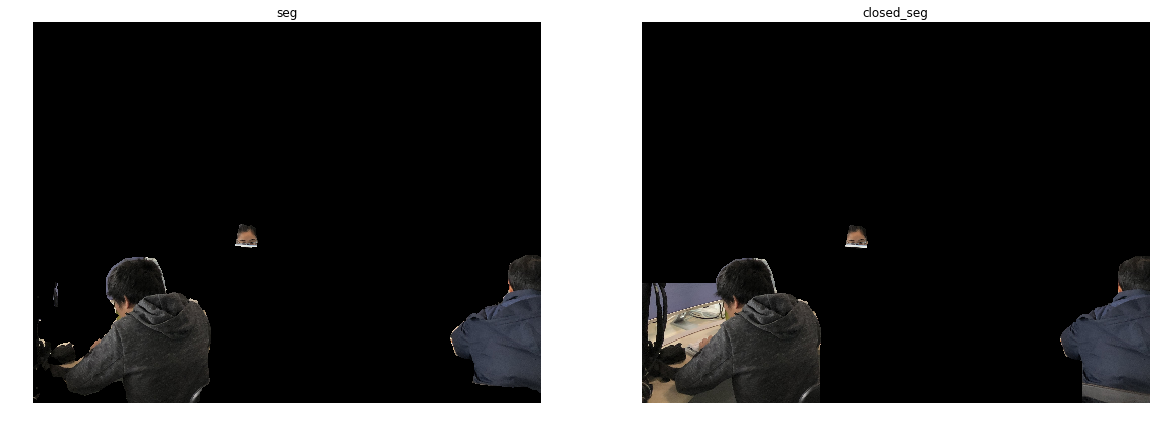

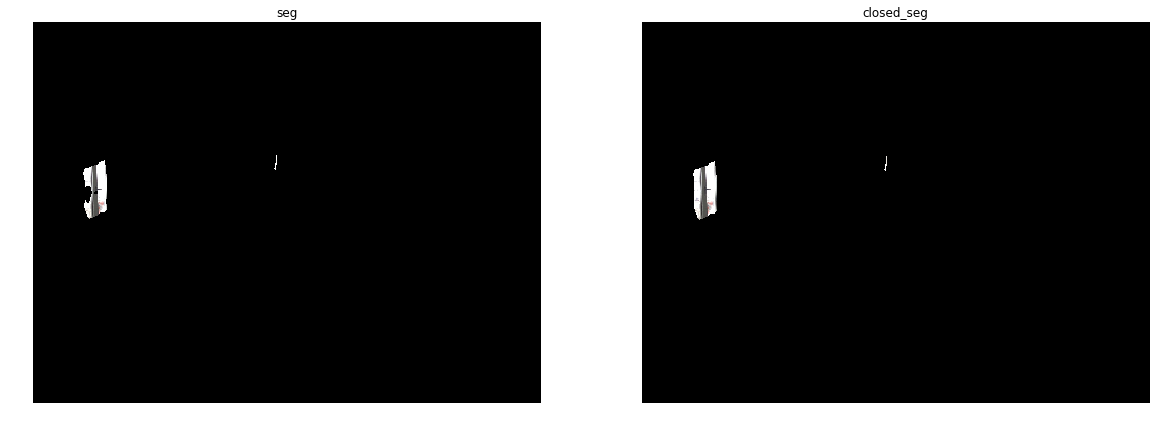

In [ ]:
seg_map_val = np.unique(seg_map)

close_kernel = np.ones((50,50),np.uint8)
closed_seg_1 = []

for i in range(len(seg_map_val)):
    plt.figure(figsize=(20,25))
    grid_spec = gridspec.GridSpec(1, 2, width_ratios=[1,1])
    
    thres = seg_map_val[i]
    mask = np.where(seg_map == thres,1,0).astype(np.uint8)
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, close_kernel)
    
    seg = lr_orig * np.expand_dims(mask,axis=-1)
    closed_seg = lr_orig * np.expand_dims(closed_mask,axis=-1)
    closed_seg_1.append(closed_seg)
    
    plt.subplot(grid_spec[0])
    plt.imshow(seg)
    plt.axis('off')
    plt.title('seg')
    
    plt.subplot(grid_spec[1])
    plt.imshow(closed_seg)
    plt.axis('off')
    plt.title('closed_seg')
    
    plt.show()

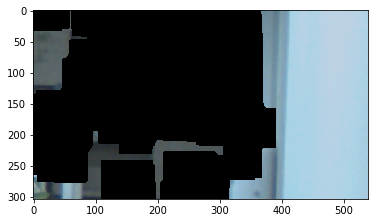

In [516]:
plt.imshow(closed_seg_1[0])

# Segment hr image

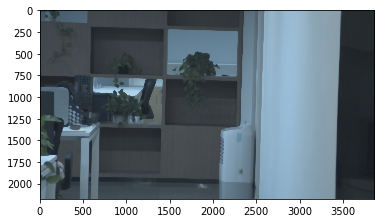

In [517]:
directory = "./hr/"
image_name = '2.png'
hr_orig = cv2.imread(directory+image_name)
hr_orig = cv2.cvtColor(hr_orig,cv2.COLOR_BGR2RGB)
img_2 = cv2.medianBlur(hr_orig,21)
h,w = img_2.shape[:2]

plt.imshow(img_2)

/home/server/anaconda3/envs/Chao/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


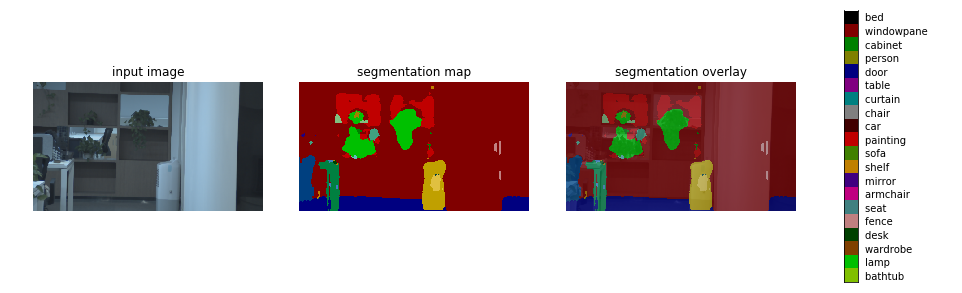

In [518]:
resized_im_2, seg_map_2 = MODEL.run(img_2)
vis_segmentation(resized_im_2, seg_map_2)

/home/server/anaconda3/envs/Chao/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


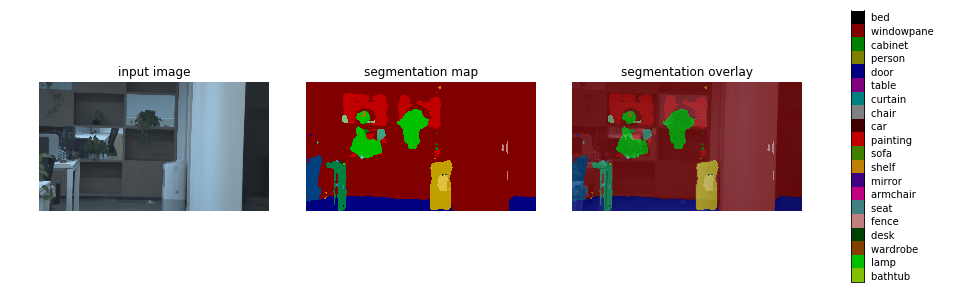

In [519]:
seg_map_2 = resize_seg_map(seg_map_2,(h,w))
seg_map_2 = resize_seg_map(seg_map_2,(h,w))
vis_segmentation(img_2, seg_map_2)

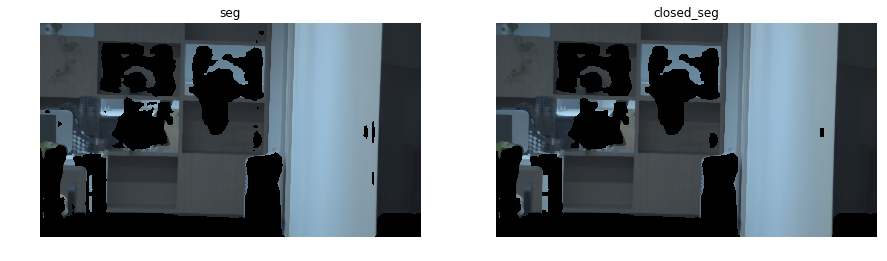

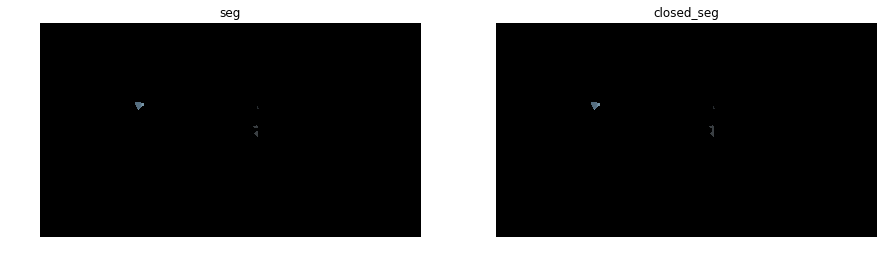

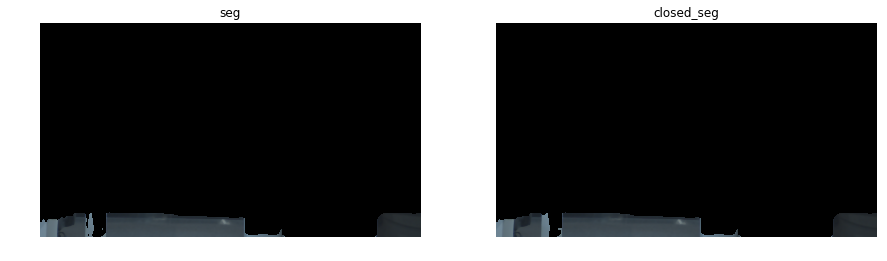

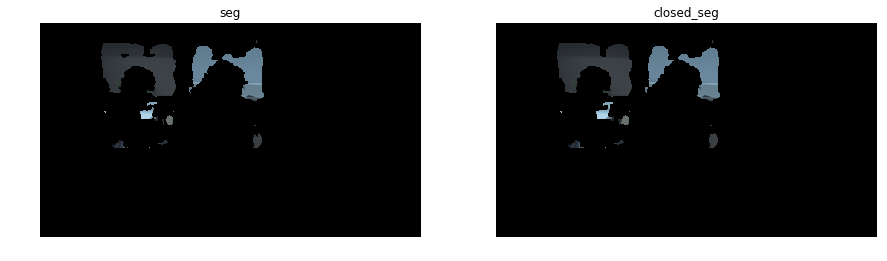

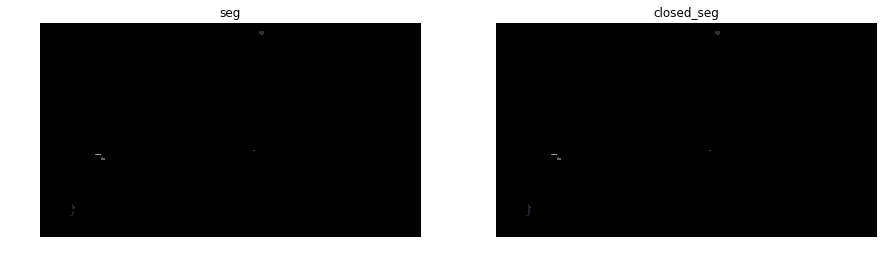

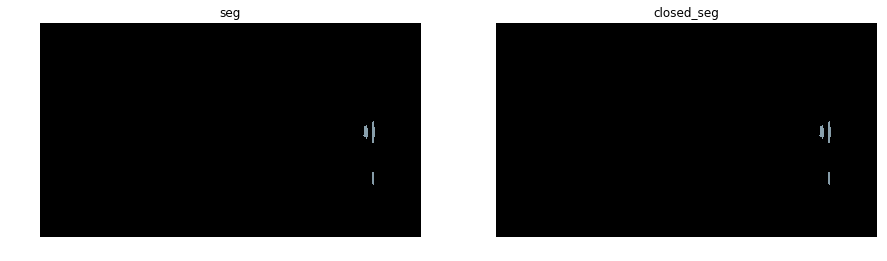

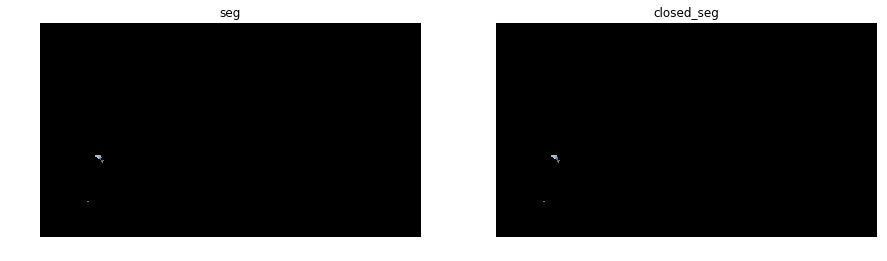

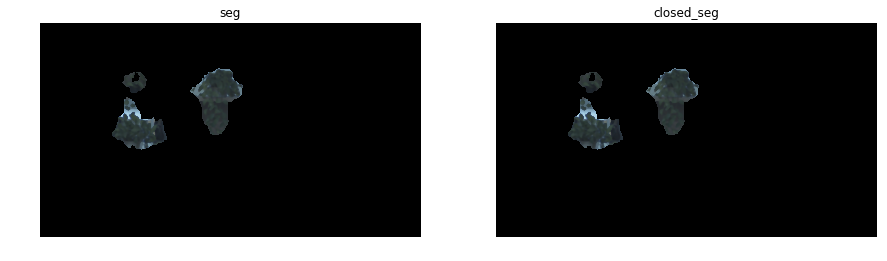

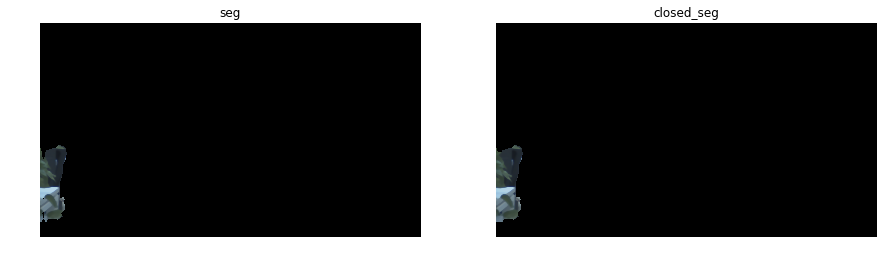

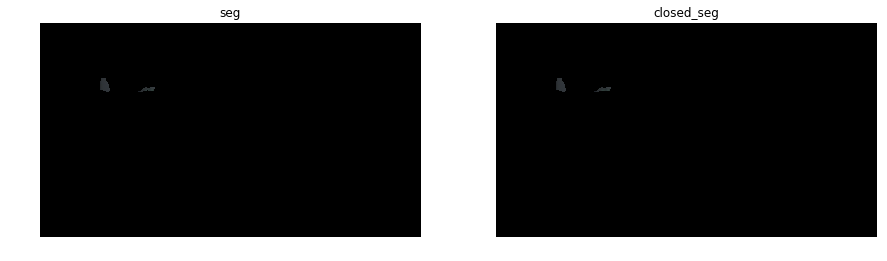

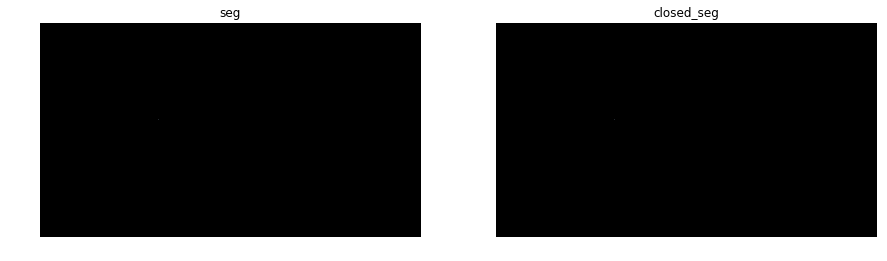

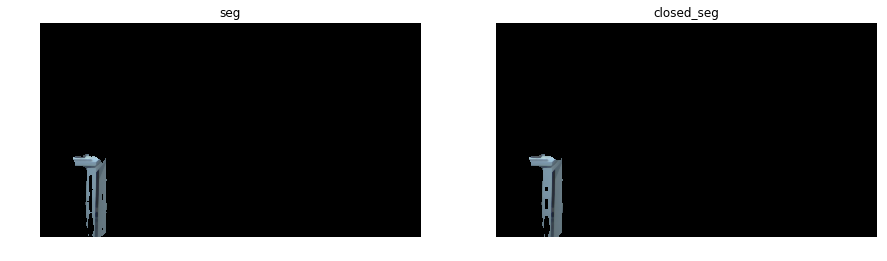

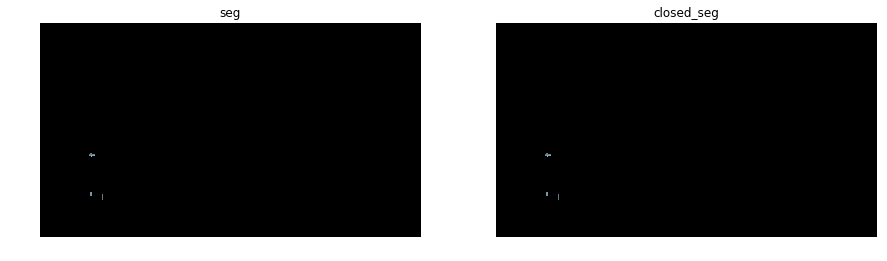

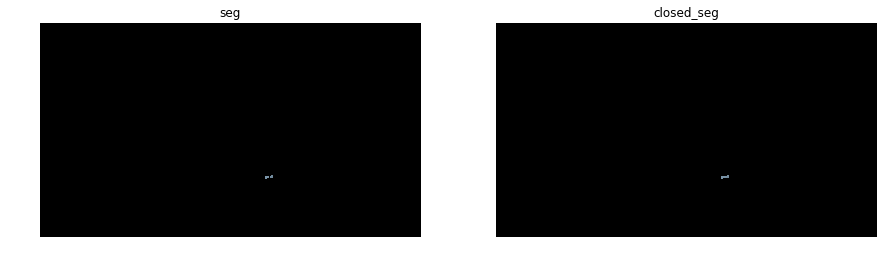

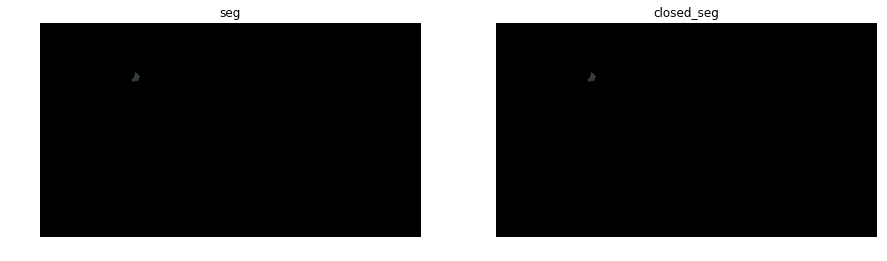

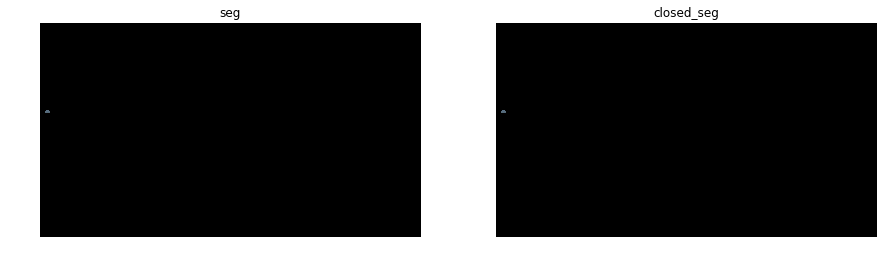

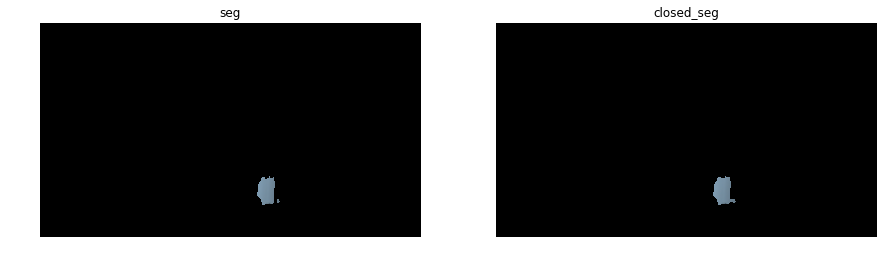

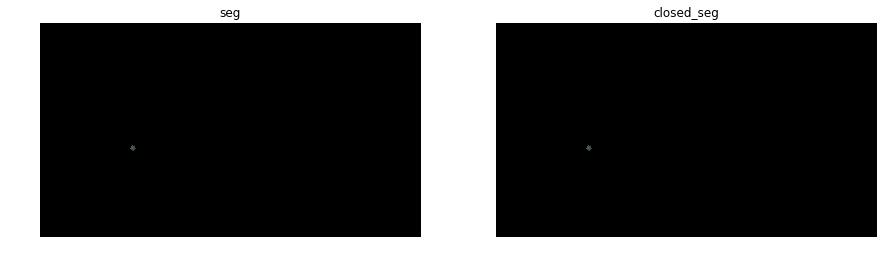

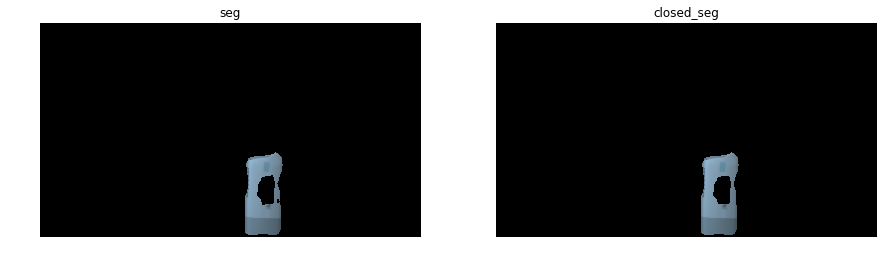

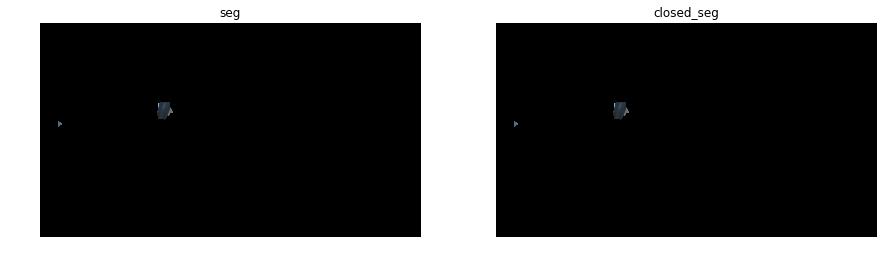

In [520]:
seg_map_val_2 = np.unique(seg_map_2)

close_kernel = np.ones((35,35),np.uint8)

closed_seg_2 = []
for i in range(len(seg_map_val_2)):
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 2, width_ratios=[1,1])
    
    thres = seg_map_val_2[i]
    mask = np.where(seg_map_2 == thres,1,0).astype(np.uint8)
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, close_kernel)
    
    seg = img_2 * np.expand_dims(mask,axis=-1)
    closed_seg = img_2 * np.expand_dims(closed_mask,axis=-1)
    closed_seg_2.append(closed_seg)
    
    plt.subplot(grid_spec[0])
    plt.imshow(seg)
    plt.axis('off')
    plt.title('seg')
    
    plt.subplot(grid_spec[1])
    plt.imshow(closed_seg)
    plt.axis('off')
    plt.title('closed_seg')
        
    plt.show()

In [504]:
seg_map_val_2 = np.unique(seg_map_2)

close_kernel = np.ones((35,35),np.uint8)
open_kernel = np.ones((10,10),np.uint8)

closed_seg_2_ds = []
for i in range(len(seg_map_val_2)):
    grid_spec = gridspec.GridSpec(1, 3, width_ratios=[1,1,1])
    
    thres = seg_map_val_2[i]
    mask = np.where(seg_map_2 == thres,1,0).astype(np.uint8)
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, close_kernel)
    opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, open_kernel)
    
    seg = resized_im_2 * np.expand_dims(mask,axis=-1)
    closed_seg = resized_im_2 * np.expand_dims(closed_mask,axis=-1)
    closed_seg_2_ds.append(closed_seg)
    opened_seg = resized_im_2 * np.expand_dims(opened_mask,axis=-1)

ValueError: operands could not be broadcast together with shapes (288,513,3) (2174,3864,1) 

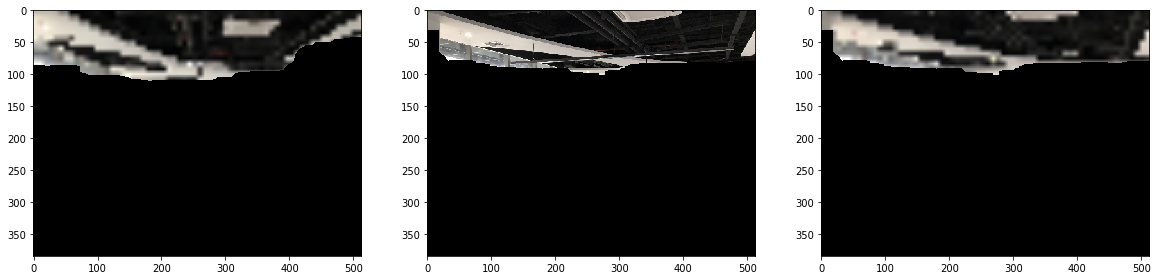

In [201]:
plt.figure(figsize=(20,25))
plt.subplot(131)
plt.imshow(closed_seg_1[3])
plt.subplot(132)
plt.imshow(closed_seg_2[3])
plt.subplot(133)
plt.imshow(closed_seg_2_ds[3])

In [216]:
def traditional_warp(hr_orig,hr_in,lr_in):
    
    hr_in = (hr_in*255.0).astype(np.uint8)
    lr_in = (lr_in*255.0).astype(np.uint8)

    hr_gray = cv2.cvtColor(hr_in, cv2.COLOR_BGR2GRAY)
    lr_gray = cv2.cvtColor(lr_in, cv2.COLOR_BGR2GRAY)

    # Run a SURF detector on both images
    surf = cv2.xfeatures2d.SURF_create(500)

    kp1, des1 = surf.detectAndCompute(hr_gray, None)
    kp2, des2 = surf.detectAndCompute(lr_gray, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # Select good matches

    good = []
    pts1 = []
    pts2 = []

    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.65*n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    MIN_MATCH_COUNT = 4
    
    print(len(good))

    # Given sufficient matching
    if len(good) > MIN_MATCH_COUNT:

        pts1 = np.int32(pts1)
        pts2 = np.int32(pts2)   

        homo_small, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
        homo_large, _ = cv2.findHomography(pts1*8, pts2*8, cv2.RANSAC, 50.0)

        warp_mat_small = np.mat(homo_small)
        warp_mat_large = np.mat(homo_large)
        
        transformed_hr_small = cv2.warpPerspective(hr_in, warp_mat_small, (int(513/8), int(384/8)))
        transformed_hr_large = cv2.warpPerspective(hr_orig, warp_mat_large, (513, 384))

    return transformed_hr_small, transformed_hr_large

In [217]:
transformed_hr_small, transformed_hr_large = traditional_warp(closed_seg_2[3],closed_seg_2_ds[3],closed_seg_1[3])

4


UnboundLocalError: local variable 'transformed_hr_small' referenced before assignment

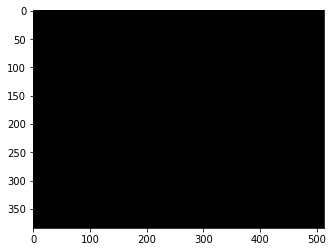

In [218]:
plt.imshow(transformed_hr_large)

/home/server/anaconda3/envs/Chao/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


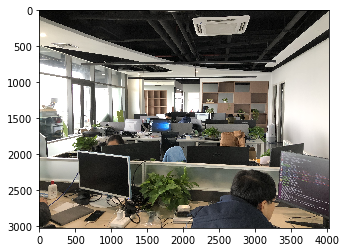

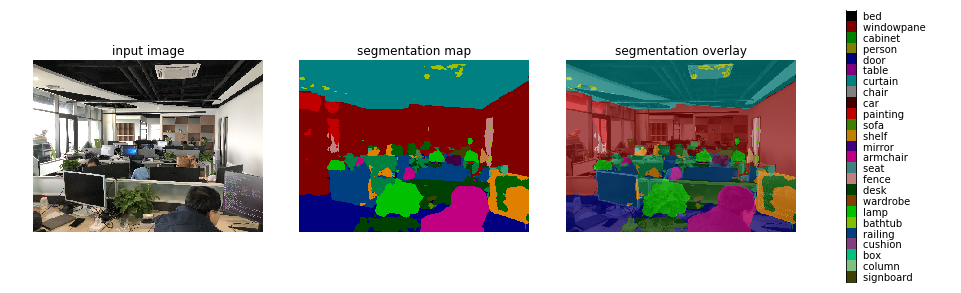

In [154]:
directory = "../dec19_2018/"
image_name = 'sample3.jpeg'
image = cv2.imread(directory+image_name)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

# image_ds = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
# for i in range(2):
#     image_ds = cv2.blur(image_ds,(2,2))
# plt.imshow(image_ds)

# for i in range(1):
#   image_ds = cv2.GaussianBlur(image_ds,(1,1),0)
# plt.imshow(image_ds)

# model = xception65_ade20k_train
resized_im, seg_map = MODEL.run(image)
vis_segmentation(resized_im, seg_map)

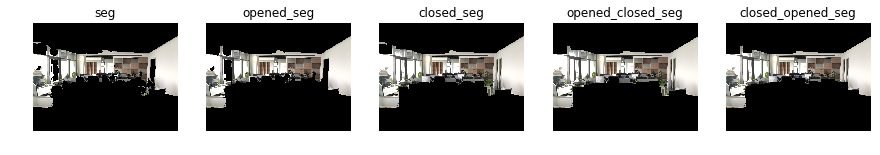

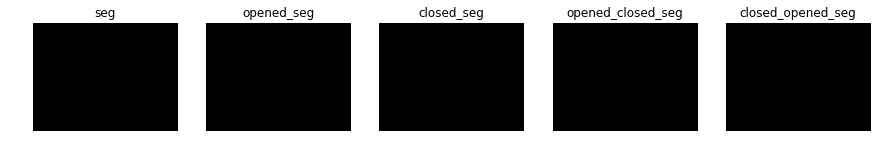

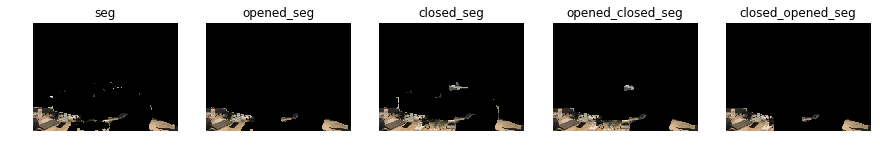

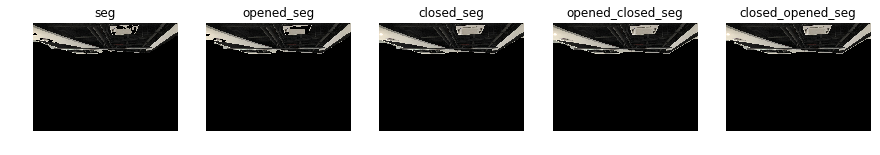

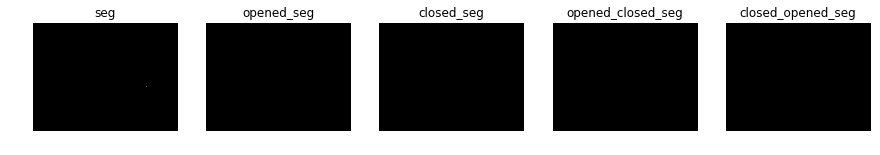

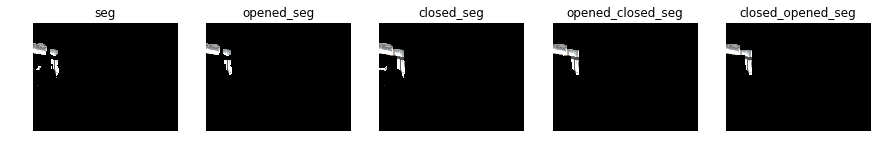

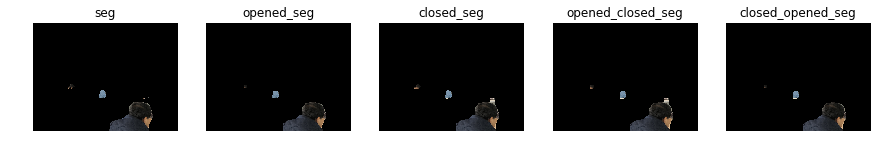

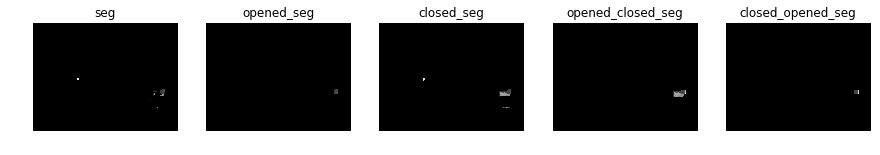

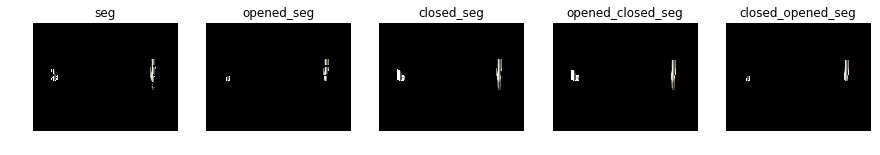

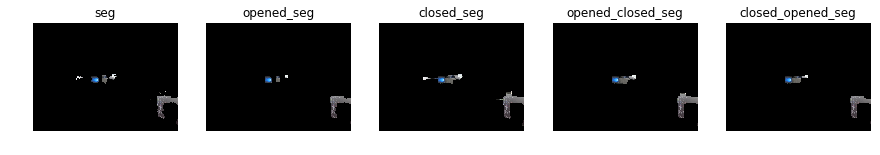

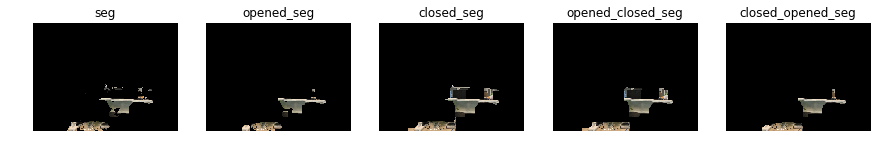

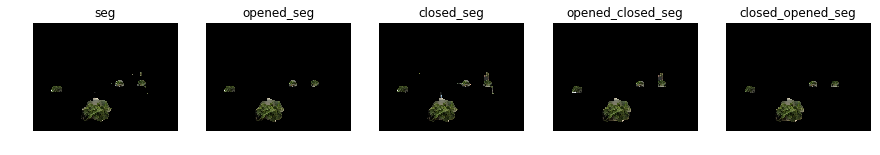

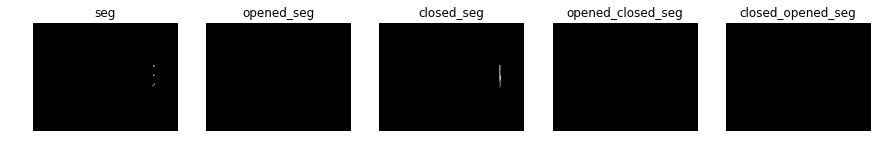

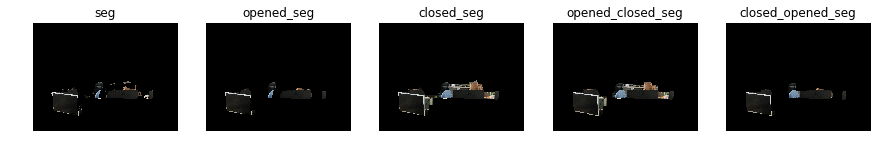

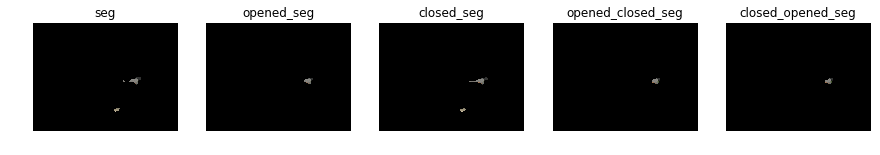

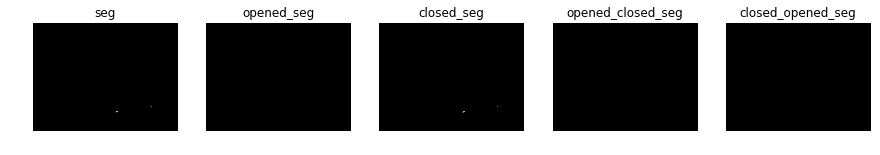

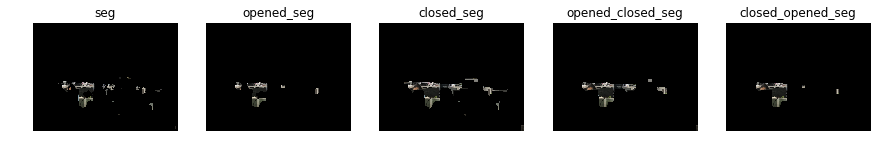

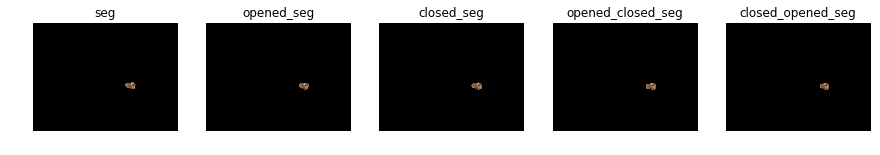

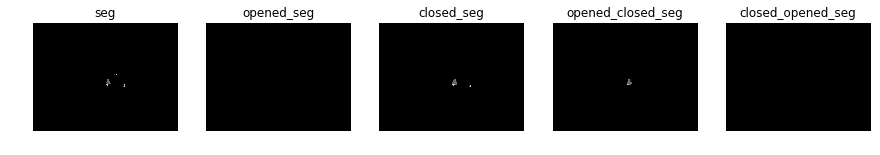

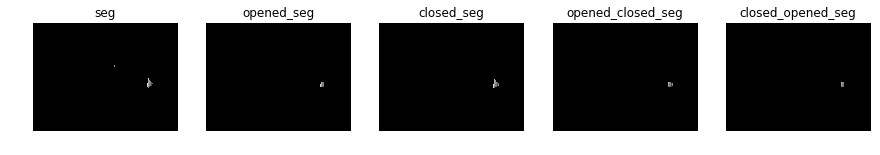

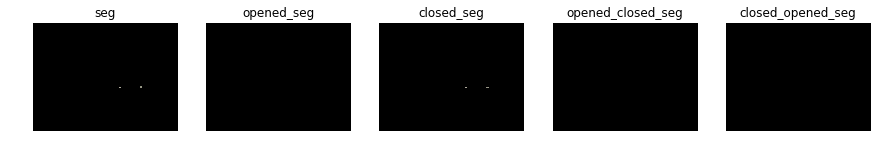

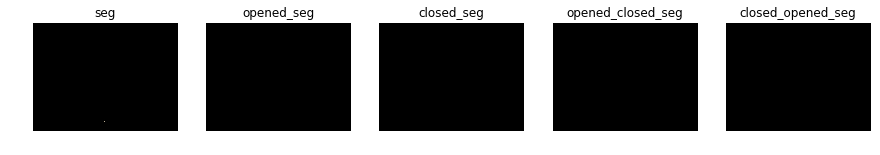

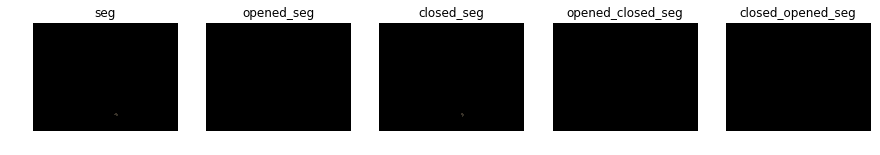

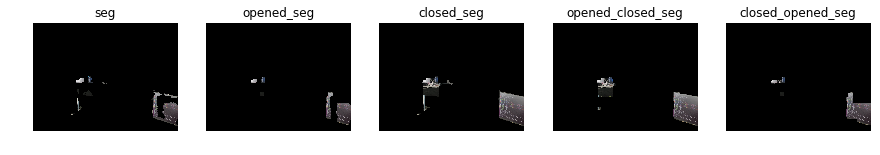

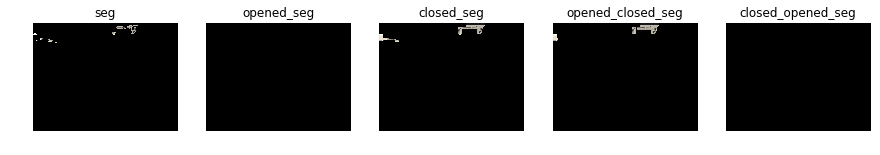

In [160]:
mask_val = set(seg_map.ravel())
mask_val = [i for i in mask_val]
open_kernel = np.ones((10,10),np.uint8)
close_kernel = np.ones((30,30),np.uint8)

for i in range(len(mask_val)):
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 5, width_ratios=[1,1,1,1,1])
    
    thres = mask_val[i]
    mask = np.where(seg_map == thres,1,0).astype(np.uint8)
    opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, open_kernel)
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, close_kernel)
    
    opened_closed_mask = cv2.morphologyEx(closed_mask, cv2.MORPH_OPEN, open_kernel)
    closed_opened_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, close_kernel)
    
    seg = resized_im * np.expand_dims(mask,axis=-1)
    opened_seg = resized_im * np.expand_dims(opened_mask,axis=-1)
    closed_seg = resized_im * np.expand_dims(closed_mask,axis=-1)
    opened_closed_seg = resized_im * np.expand_dims(opened_closed_mask,axis=-1)
    closed_opened_seg = resized_im * np.expand_dims(closed_opened_mask,axis=-1)
    
    
    plt.subplot(grid_spec[0])
    plt.imshow(seg)
    plt.axis('off')
    plt.title('seg')
    
    plt.subplot(grid_spec[1])
    plt.imshow(opened_seg)
    plt.axis('off')
    plt.title('opened_seg')
    
    plt.subplot(grid_spec[2])
    plt.imshow(closed_seg)
    plt.axis('off')
    plt.title('closed_seg')
    
    plt.subplot(grid_spec[3])
    plt.imshow(opened_closed_seg)
    plt.axis('off')
    plt.title('opened_closed_seg')
    
    plt.subplot(grid_spec[4])
    plt.imshow(closed_opened_seg)
    plt.axis('off')
    plt.title('closed_opened_seg')
    
    plt.show()